# 突变检测-全部数据

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
#数据读取
file_path = '/Users/86180/Desktop/赛题B/全部数据/附件2-行业日负荷数据.csv'
data = pd.read_csv(file_path,parse_dates=['数据时间'],index_col=[1])

#数据分解
#大工业great，非普ind，商业com
data_great= data.loc[data['行业类型']=='大工业用电'].drop('行业类型',axis = 1)
data_ind=data.loc[data['行业类型']=='非普工业'].drop('行业类型',axis = 1)
data_ord=data.loc[data['行业类型']=='普通工业'].drop('行业类型',axis = 1)
data_com=data.loc[data['行业类型']=='商业'].drop('行业类型',axis = 1)

data_great_max = data_great.drop('有功功率最小值（kw）',axis = 1)
data_great_min = data_great.drop('有功功率最大值（kw）',axis = 1)
data_ind_max = data_ind.drop('有功功率最小值（kw）',axis = 1)
data_ind_min = data_ind.drop('有功功率最大值（kw）',axis = 1)
data_ord_max = data_ord.drop('有功功率最小值（kw）',axis = 1)
data_ord_min = data_ord.drop('有功功率最大值（kw）',axis = 1)
data_com_max = data_com.drop('有功功率最小值（kw）',axis = 1)
data_com_min = data_com.drop('有功功率最大值（kw）',axis = 1)

In [59]:
def process(data):
    # 重采样D
    # 将有断点的时间序列变成连续时间序列
    data_fill = data.resample('D').mean()
    # 用中位数填充空缺值
    data_fill[data_fill.isna().iloc[:,0]] = data.median()
    # 将每天的减去每天中位数，使所有点的的功率变化都在一条水平线上
    data_day_median = data_fill.median().values
    data_values = [data_fill.iloc[i,0] - data_day_median[0] for i in range(data_fill.shape[0])]
    #plt.plot(data_values)
    
    # 利用正态分布的3σ原则，得出异常点
    data_values = pd.Series(data_values)
    mean = data_values.mean()
    std = data_values.std()
    rule=(mean-3*std > data_values) | (mean+3*std < data_values)
    #rule.sum()
    # 先用中位数填充异常点，使异常点落在大部分取值范围中
    data_del_wrong = data_values
    data_del_wrong[rule] = data_values.median()
    #plt.plot(data_del_wrong[:])
    # 再用滑动平均数去给异常点赋值，使异常点的数值与周围5个点的数值连续
    data_del_wrong[rule] = pd.Series(data_del_wrong).rolling(5, center=True).mean()[rule]
    
    #先用五天平均值作为一个数据点
    data_rsp5D= data_del_wrong[:data_del_wrong.shape[0]//5-1]
    for i in range(data_del_wrong.shape[0]//5):
        sum=0
        for j in range(5):
            sum+=data_del_wrong[5*i+j]
        data_rsp5D[i]= sum / 5
        
    # 用滑动窗口，使曲线平滑，去除噪声
    window = 2
    data_smooth = pd.Series(data_rsp5D).rolling(window, center=True).mean()
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data_values[j]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data_values[len(data_smooth) - j - 1]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)    
   
    return data_smooth


In [60]:
data_greatmax = process(data_great_max)
data_greatmin = process(data_great_min)

data_indmax = process(data_ind_max)
data_indmin = process(data_ind_min)

data_commax = process(data_com_max)
data_commin = process(data_com_min)

data_ordmax = process(data_ord_max)
data_ordmin = process(data_ord_min)

### 时间序列突变点检测（每种方法求交集）

# SNHT

In [61]:
def SNHT_change_point_detection(data):
    data = np.array(data)
    data_mean = np.mean(data)
    n = data.shape[0]
    k = range(1,n)
    sigma = np.sqrt(np.sum((data-np.mean(data))**2)/(n-1))
    TK = [x*(np.sum((data[0:x]-data_mean)/sigma)/x)**2+
          (n-x)*(np.sum((data[x:n]-data_mean)/sigma)/(n-x))**2 for x in k]
    T = np.max(TK)
    K = list(TK).index(T)+1
    return K
    

In [63]:
SNHT_greatmax = SNHT_change_point_detection(data_great_min)
SNHT_greatmax 


54

#  Pettitt

In [64]:
def Pettitt_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n         = inputdata.shape[0]
    k = range(n)
    inputdataT = pd.Series(inputdata)
    r = inputdataT.rank()
    Uk = [2*np.sum(r[0:x])-x*(n + 1) for x in k]
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = Uka.index(U)
    pvalue         = 2 * np.exp((-6 * (U**2))/(n**3 + n**2))
    if pvalue <= 0.05:
        change_point_desc = '显著'
    else:
        change_point_desc = '不显著'
    #Pettitt_result = {'突变点位置':K,'突变程度':change_point_desc}
    return K #,Pettitt_result

In [66]:
Petti_greatmin = Pettitt_change_point_detection(data_greatmin)
Petti_greatmin

73

## Buishand U

In [67]:
def Buishand_U_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    inputdata_mean = np.mean(inputdata)
    n  = inputdata.shape[0]
    k = range(n)
    Sk = [np.sum(inputdata[0:x+1] - inputdata_mean) for x in k]
    sigma = np.sqrt(np.sum((inputdata-np.mean(inputdata))**2)/(n-1))
    U = np.sum((Sk[0:(n - 2)]/sigma)**2)/(n * (n + 1))
    Ska = np.abs(Sk)
    S = np.max(Ska)
    K = list(Ska).index(S) + 1
    Skk = (Sk/sigma)
    return K


In [68]:
Buishand_greatmax = Buishand_U_change_point_detection(data_greatmax)
Buishand_greatmax

72

## Mann-Kendall

In [72]:
def Kendall_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    # 正序列
    # 定义累计量(秩）序列Sk，初始值=0
    Sk = [0]
    # 定义统计量UFk，初始值 =0
    UFk = [0]
    # 定义Sk序列元素s，初始值 =0
    s = 0
    Exp_value = [0]
    Var_value = [0]
    # i从1开始,此公式中，令UFk(0)=0
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
        ################################################
    # 逆序列
    # 定义逆序累计量序列Sk2，长度与inputdata一致，初始值=0
    Sk2 = [0]
    # 定义逆序统计量UBk，长度与inputdata一致，初始值=0
    UBk  = [0]
    UBk2  = [0]
    # s归0
    s2  =  0
    Exp_value2  = [0]
    Var_value2  = [0]
    # 按时间序列逆转样本y
    inputdataT = list(reversed(inputdata))
    # i从2开始，因为根据统计量UBk公式，i=1时，Sk2(1)、E(1)、Var(1)均为0
    # 此时UBk无意义，因此公式中，令UBk(1)=0
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    # 由于对逆序序列的累计量Sk2的构建中，依然用的是累加法，即后者大于前者时s加1，
    # 则s的大小表征了一种上升的趋势的大小，而序列逆序以后，应当表现出与原序列相反
    # 的趋势表现，因此，用累加法统计Sk2序列，统计量公式(S(i)-E(i))/sqrt(Var(i))
    #也不应改变，但统计量UBk应取相反数以表征正确的逆序序列的趋势
    #  UBk(i)=0-(Sk2(i)-E)/sqrt(Var)
    # 此时上一步得到的UBk表现的是逆序列在逆序时间上的趋势统计量
    # 与UFk做图寻找突变点时，2条曲线应具有同样的时间轴，因此
    # 再按时间序列逆转结果统计量UBk，得到时间正序的UBkT，
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    # 找出交叉点
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
    '''
    # 做突变检测图时，使用UFk和UBkT
    plt.figure(figsize=(10,5))
    plt.plot(range(1,n+1) ,UFk  ,label='UFk') # UFk
    plt.plot(range(1,n+1) ,UBkT ,label='UBk') # UBk
    plt.ylabel('UFk-UBk')
    x_lim = plt.xlim()
    plt.plot(x_lim,[-1.96,-1.96],'m--',color='r')
    plt.plot(x_lim,[  0  ,  0  ],'m--')
    plt.plot(x_lim,[+1.96,+1.96],'m--',color='r')
    plt.legend(loc=2) # 图例
    plt.show()
    '''     
    return K


In [73]:
MK_greatmax = Kendall_change_point_detection(data_greatmax)
#MK_greatmax  [67, 105, 125]
MK_greatmin = Kendall_change_point_detection(data_greatmin)
#MK_greatmin [4, 11, 71, 98, 138]
MK_indmax = Kendall_change_point_detection(data_indmax)
MK_indmin = Kendall_change_point_detection(data_indmin)
MK_ordmax = Kendall_change_point_detection(data_ordmax)
MK_ordmin = Kendall_change_point_detection(data_ordmin)
MK_commax = Kendall_change_point_detection(data_commax)
MK_commin = Kendall_change_point_detection(data_commin)
#MK_indmax [37, 86, 108]
#MK_indmin [32, 88, 119]
#MK_commax [66]
#MK_commin [16, 68, 105, 118]
#MK_ordmax [5, 9, 72]
#MK_ordmin [117]

# 滑动T检测

In [74]:
# v:自由度
def get_tvalue(v, sig_level):
    t_values = pd.read_excel(r'/Users/86180/Desktop/赛题B/全部数据/t_values.xlsx')
    return t_values[t_values['n'] == v][sig_level].values


In [76]:
# 传入时间序列以及待检验数据
# data:数据， step：步长， sig_level：显著水平
def huaTTest(data, step, sig_level):
    datacount = len(data)
    v = 2*step-2  # 自由度
    t_value = get_tvalue(v, sig_level)  # t检验值
    n1 = step
    n2 = step
    t = np.zeros(len(data))
    c = 1.0 / n1 + 1.0 / n2

    for i in range(step-1, datacount-step):
        data1 = data[i-step+1:i+1]
        data2 = data[i+1:i+step+1]
        # 计算均值
        x1_mean = data1.mean()
        x2_mean = data2.mean()
        # 计算方差
        s1 = data1.var()
        s2 = data2.var()
        sw2 = (n1*s1 + n2*s2)/(n1+n2-2.0)
        t[i - step + 1] = (x1_mean - x2_mean) / np.sqrt(sw2 * c)
    return t, t_value

In [77]:
def resampleTime(time):
    time_rsp5D= time[:]
    a=2
    i=0
    while(a<time.shape[0]):
          time_rsp5D[i]=time[a]
          a+=5
          i+=1
    time_rsp5D = time_rsp5D[:i]
    return time_rsp5D   

In [78]:
# 获取数据-时间
file_path = '/Users/86180/Desktop/赛题B/全部数据/附件2-行业日负荷数据.csv'
data_xls = pd.read_csv(file_path)
timegreattmp = data_xls.loc[data_xls['行业类型']=='大工业用电'].drop('行业类型',axis = 1)['数据时间']
timeindtmp = data_xls.loc[data_xls['行业类型']=='非普工业'].drop('行业类型',axis = 1)['数据时间']
timeordtmp = data_xls.loc[data_xls['行业类型']=='普通工业'].drop('行业类型',axis = 1)['数据时间']
timecomtmp = data_xls.loc[data_xls['行业类型']=='商业'].drop('行业类型',axis = 1)['数据时间']
timegreat=np.array(timegreattmp)
timeind=np.array(timeindtmp)
timeord=np.array(timeordtmp)
timecom=np.array(timecomtmp)
time_great = resampleTime(timegreat)
time_ind = resampleTime(timeind)
time_ord = resampleTime(timeord)
time_com = resampleTime(timecom)

In [79]:
def huaT(data_smooth,time):
    casa = np.array(data_smooth)
    datacount = len(casa)
    steps = range(2,4)
    dict = {}  # 存储显著变化的点信息
    # 按照可取步长计算
    for step in tqdm(steps, ncols=80, desc=u'滑动T检验进度'):
        t, t_value = huaTTest(casa, step, 0.05)
        t = t[t != 0]
        sig_values = []  # 存储显著变化值
        T_values = [] #显著变化值的t值
        for i in range(len(t)):
            if np.abs(t[i]) > t_value:
                sig_values.append(time[i + step - 1])
                T_values.append(t[i])
        if sig_values:
            # 将结果存入词典
            dict_key = 'step'+str(step)
            dict[dict_key] = sig_values
        #绘图    
        fig, ax = plt.subplots(figsize=(9, 5), sharey=True)
        fontdict = {'size': 12, 'color': 'k'}

        x = time[step-1:datacount-step]
        #ax.set_xticks(x[::2])
        # ax.set_xlim((time[0], time[datacount-step]))
        ax.plot(x, t, c='k', linewidth=1.5, label=u'滑动T值', zorder=1)
        # 添加显著水平线
        ax.hlines(y=t_value, xmin=np.min(x), xmax=np.max(x), linewidth=1.5, linestyles='--', label=u'0.05显著水平')
        ax.hlines(y=-t_value, xmin=np.min(x), xmax=np.max(x), linewidth=1.5, linestyles='--', label=None)
        # 修改刻度线指向
        ax.tick_params(left=True, bottom=True, direction='in', labelsize=12)
        # 添加坐标轴标签
        ax.set_xlabel(u'时间', fontdict=fontdict)
        ax.set_ylabel('T', fontdict=fontdict)
        # 设置图例
        ax.legend(bbox_to_anchor=(0.95, 0.95), facecolor='w', frameon=False)

        # 保存文件
        basepath = r'/Users/86180/Desktop/'
        filename = r'ordmaxhuaTstep%d.png'%step
        savepath = basepath + filename

        # 检查保存目录是否存在
        if not os.path.exists(basepath):
            print('创建保存目录')
            os.mkdir(basepath)
            print('创建完成！')
        plt.savefig(savepath)
    # 写入数据
    # 创建workbool和sheet对象
    workbook = xlwt.Workbook()
    sheet1 = workbook.add_sheet('sheet1', cell_overwrite_ok=True)

    # 写入头部信息
    for head in range(len(list(dict.keys()))):
        sheet1.write(0, head, label=list(dict.keys())[head])

    # 写入数据
    # 获取最大行数
    max_row = max([len(list(dict.values())[i]) for i in range(len(list(dict.values())))])
    for row in range(max_row):
        for col in range(len(list(dict.keys()))):
            if row < len(list(dict.values())[col]):
                sheet1.write(row+1, col, label=list(dict.values())[col][row])  # 将np.int32转换为int

    # 保存结果
    workbook.save(r'/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/普通工业/huaTord_max.xls')
    


In [80]:
def huaT2(data_smooth,time):
    casa = np.array(data_smooth)
    datacount = len(casa)
    steps = range(2,4)
    dict1 = {}  # 存储显著变化的点的时间
    dict2 = {} #显著变化点的T值
    # 按照可取步长计算
    for step in tqdm(steps, ncols=80, desc=u'滑动T检验进度'):
        t, t_value = huaTTest(casa, step, 0.05)
        t = t[t != 0]
        sig_values = []  # 存储显著变化值
        T_values = [] #显著变化值的t值
        for i in range(len(t)):
            if np.abs(t[i]) > t_value:
                sig_values.append(time[i + step - 1])
                T_values.append(t[i])
        if T_values:
            # 将结果存入词典
            dict_key = 'step'+str(step)
            dict1[dict_key] = sig_values
            dict2[dict_key] = T_values
    # 写入数据
    # 创建workbool和sheet对象
    workbook = xlwt.Workbook()
    sheet1 = workbook.add_sheet('sheet1', cell_overwrite_ok=True)
    #sheet2 = workbook.add_sheet('sheet2', cell_overwrite_ok=True)

    # 写入头部信息
    for head in range(len(list(dict1.keys()))):
        sheet1.write(0, head, label=list(dict1.keys())[head])

    # 写入数据
    # 获取最大行数
    max_row = max([len(list(dict1.values())[i]) for i in range(len(list(dict1.values())))])
    for row in range(max_row):
        for col in range(0,len(list(dict1.keys())),2):
            if row < len(list(dict1.values())[col]):
                sheet1.write(row+1, col, label=list(dict1.values())[col][row])  # 将np.int32转换为int
                sheet1.write(row+1, col+1, label=list(dict2.values())[col][row])  # 将np.int32转换为int

    # 保存结果
    workbook.save(r'/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/滑动T-结果/商业/T_min.xls')
    


In [81]:

data_commin = process(data_com_min)
huaT2(data_commin,time_com)

滑动T检验进度: 100%|██████████████████████████████| 2/2 [00:00<00:00, 66.64it/s]


滑动T检验进度: 100%|██████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]


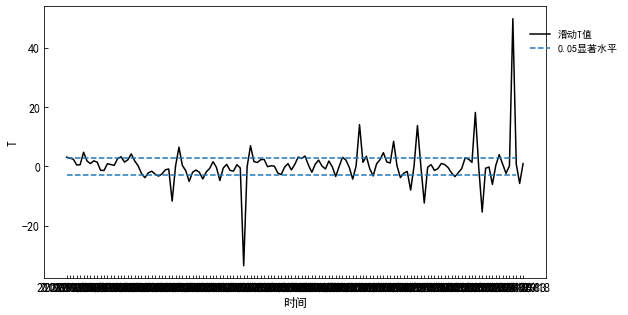

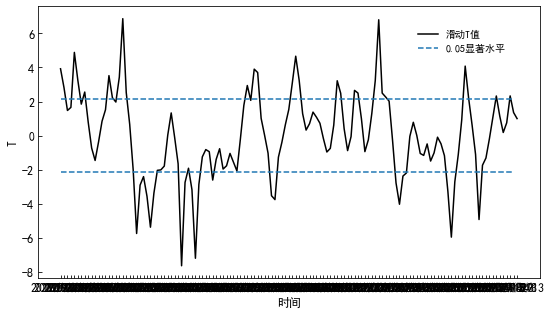

In [82]:
huaT(data_ordmax,time_ord)